In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi

Wed May 18 10:28:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Main Libraries

In [ ]:
pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 18.2 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import datetime
import math
import itertools 
import pickle
import time
import os
import sys
import shutil
import keras
import glob
import cv2
import random
import textwrap
import scipy.ndimage as ndimage
import seaborn as sns

print("TF version:", tf.__version__)

from sklearn.model_selection import train_test_split
from math import ceil, floor
from pathlib import Path
from tqdm import tqdm
from sklearn import metrics
from tqdm.notebook import tqdm
from IPython.display import clear_output
from PIL import Image, ImageDraw, ImageFont

TF version: 2.8.0


##Setup Colab

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

##Unzip Datasets

In [ ]:
!unzip "/content/drive/My Drive/ColabNotebooks/Datasets/Kvasir-capsule-dataset.zip"

Archive:  /content/drive/My Drive/ColabNotebooks/Datasets/Kvasir-capsule-dataset.zip
replace Kvasir-capsule Dataset/Ampulla of vater/eb0203196e284797_1157.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


##Initialize

In [ ]:
labeled_data_root = pathlib.Path('/content/Kvasir-capsule Dataset')
# unlab_data_root = pathlib.Path('/content/unlabeled-images')

# Primary directory
record_dir = "./records/{}".format("labelled_model")
pathlib.Path(record_dir).mkdir(parents=True, exist_ok=True) # record_directory

cache_dir = "./cache"
pathlib.Path(cache_dir).mkdir(parents=True, exist_ok=True) # cache directory

##Split Dataset

In [ ]:
def split_dataset():

    train_split = float(0.7)
    test_split = float(0.7)+float(0.2)
    random.seed(2800)
    
    # listdir() returns a list containing the names of the entries in the directory
    class_names = os.listdir(labeled_data_root)
    image_folders = [os.path.join(labeled_data_root, class_name) for class_name in class_names]
    
    num_samples = len(list(Path(labeled_data_root).glob('*/*')))

    train_folders = [os.path.join('labeled_data', 'train', name) for name in class_names]
    test_folders = [os.path.join('labeled_data', 'test', name) for name in class_names]
    val_folders = [os.path.join('labeled_data', 'val', name) for name in class_names]

    for folder in train_folders:
      Path(folder).mkdir(parents=True, exist_ok=True)

    for folder in test_folders:
      Path(folder).mkdir(parents=True, exist_ok=True)
                              
    for folder in val_folders:
      Path(folder).mkdir(parents=True, exist_ok=True)

    tqdm_img = tqdm(total=num_samples, desc='Images', position=0)

    # split all the classes equally to test, train and val
    for idx, directory in enumerate(image_folders):

        random.seed(2800)
        imagenames = os.listdir(directory)
        imagenames.sort() # make sure that the image filenames have a fixed order before shuffling
        random.shuffle(imagenames) # shuffles the ordering of image filenames (deterministic given the chosen seed)
        num_samples = len(imagenames)

        imagenames = np.array(imagenames)
        imagenames_split = np.split(imagenames, [floor(num_samples*train_split), floor(num_samples*test_split)])
        
        dataset = {'train': imagenames_split[0],
                   'test': imagenames_split[1],
                   'val': imagenames_split[2]}

        for split in dataset:
            output = os.path.join('labeled_data', split, directory.split("/")[-1])
            for filename in dataset[split]:
                filename = os.path.join(directory, filename)
                image_resize(filename, output)
                tqdm_img.update(1)

In [ ]:
def image_resize(filename, output_dir):
    image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_LINEAR)
    path = os.path.join(output_dir, filename.split('/')[-1])
    cv2.imwrite(path, image) # Save the image in the output directory

In [ ]:
split_dataset()

Images:   0%|          | 0/47238 [00:00<?, ?it/s]

##Build and form the train, test and val datasets

In [ ]:
BATCH_SIZE = 8
CLASS_NAMES = None
NUMBER_CLASSES = 0
DATASET_SIZE_TRAIN = None
DATASET_SIZE_TEST = None
DATASET_SIZE_VAL = None
DATASET_SIZE_UNLAB = None
STEPS_TRAIN = None
STEPS_TEST = None
STEPS_VAL = None
RAW_TRAIN_DATASET = None
AUTOTUNE = tf.data.experimental.AUTOTUNE

# function to load input image, preprocess it and get label
def load_label_images(image_path):
    # read the image from database, decode it, convert the data type to
	  # floating point, and then resize it
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_raw, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])

    # parse the class label from the file path
    str_targets = tf.strings.split(image_path, os.path.sep)[-2]
    label_integer = tf.reduce_min(tf.where(tf.equal(str_targets, CLASS_NAMES)))
    label = tf.dtypes.cast(label_integer, tf.int32)

    return image, label

def build_datasets():

    global CLASS_NAMES
    global NUMBER_CLASSES
    global DATASET_SIZE_TRAIN
    global DATASET_SIZE_TEST
    global DATASET_SIZE_VAL
    global STEPS_TRAIN
    global STEPS_TEST
    global STEPS_VAL
    global RAW_TRAIN_DATASET

    labeled_data_root = pathlib.Path('/content/labeled_data')
    np.random.seed(seed=2800)

    class_names = np.array([item.name for item in labeled_data_root.glob('train/*')])

    CLASS_NAMES = class_names
    NUMBER_CLASSES = len(class_names)

    model_class_names = list(class_names)
    handle = open(record_dir+"/model_class_names.pkl", 'wb')
    pickle.dump(model_class_names, handle)
    
    dataset = {'train': str(labeled_data_root/'train'/'*/*.*g'),
          'test': str(labeled_data_root/'test'/'*/*.*g'),
          'val': str(labeled_data_root/'val'/'*/*.*g')}

    DATASET_SIZE_TRAIN = len(list(glob.glob(dataset["train"])))
    DATASET_SIZE_TEST = len(list(glob.glob(dataset["test"])))
    DATASET_SIZE_VAL = len(list(glob.glob(dataset["val"])))
    
    for split in dataset:
        dataset[split] = tf.data.Dataset.list_files(dataset[split],
                                    shuffle=True,
                                    seed=tf.constant(2800, tf.int64)
                                    )
    
    # Map labels with the images from tf.dataset to create "train", "test", "val" datasets
    for split in dataset:
        dataset[split] = dataset[split].map(load_label_images, num_parallel_calls=AUTOTUNE)
    
    RAW_TRAIN_DATASET = dataset["train"] # Clean dataset of the "train" split
    
    print("[INFO] loading the dataset...")

    # training dataset split will go through a resample, suffle, repeat, data augment,
    # and prefetched phase
    dataset["train"] = resample(dataset["train"])
    dataset["train"] = (
      dataset["train"]
      .shuffle(buffer_size=3000, seed=tf.constant(2800, tf.int64))
      .repeat()
      .map(dataset_augmentation(), num_parallel_calls=AUTOTUNE)
      .batch(BATCH_SIZE, drop_remainder=False)
      .prefetch(buffer_size=AUTOTUNE)
    )

    # testing dataset split will go through a caching, suffle, repeat,
    # and prefetched phase
    cache_string = "{}/{}_{}".format(cache_dir, 128, "test")
    dataset["test"] = (
      dataset["test"]
      .cache(cache_string)
      .shuffle(buffer_size=3000, seed=tf.constant(2800, tf.int64))
      .repeat()
      .batch(BATCH_SIZE, drop_remainder=False)
      .prefetch(buffer_size=AUTOTUNE)
    )

    # testing dataset split will go through a caching, suffle, repeat,
    # and prefetched phase
    cache_string = "{}/{}_{}".format(cache_dir, 128, "val")
    dataset["val"] = (
      dataset["val"]
      .cache(cache_string)
      .shuffle(buffer_size=3000, seed=tf.constant(2800, tf.int64))
      .repeat()
      .batch(BATCH_SIZE, drop_remainder=False)
      .prefetch(buffer_size=AUTOTUNE)
    )

    print("[INFO] train, test and val datasets created")

    STEPS_TRAIN = DATASET_SIZE_TRAIN//BATCH_SIZE
    STEPS_TEST = DATASET_SIZE_TEST//BATCH_SIZE
    STEPS_VAL = DATASET_SIZE_VAL//BATCH_SIZE
    
    return dataset

In [ ]:
def count_class_samples(dataset, num_classes):
    count = np.zeros(num_classes) # returns a new array with zeros according to the class count
    for img, lab in dataset:
        count[lab] += 1
    return count

Resample Dataset

In [ ]:
def resample(dataset):

    datasets = []
    cache_dir = './cache/{}_resampled_{}/'.format(128, 'train')
    pathlib.Path(cache_dir).mkdir(parents=True, exist_ok=True) # create cache directory
    
    for i in range(NUMBER_CLASSES): # NUMBER_CLASSES = 23
        data = dataset.filter(lambda img, lab: lab==i)
        data = data.cache(cache_dir+'{}_dataset'.format(i))
        
        data = data.repeat()
        datasets.append(data)
    
    target_dist = [ 1.0/NUMBER_CLASSES ] * NUMBER_CLASSES
    balanced_dataset = tf.data.experimental.sample_from_datasets(datasets, weights=target_dist, seed=2800)
    
    return balanced_dataset

Data Augmentation

In [ ]:
def dataset_augmentation():

    tf.random.set_seed(2800) # global seed
    
    def image_augment(image, label):

        degree = tf.random.normal([])*360
        image = tfa.image.rotate(image, degree * math.pi / 180, interpolation='BILINEAR')
        image = tf.image.resize_with_crop_or_pad(image, 138, 138)
        image = tf.image.random_crop(image, (128, 128, 3), seed=2800)
        image = tf.image.random_brightness(image, max_delta=0.2, seed=2800)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=2800)
        # image = tf.image.random_contrast(image, lower=0.5, upper=1.5, seed=2800)
        # image = tf.image.random_hue(image, max_delta=0.2, seed=2800)
        image = tf.image.random_flip_left_right(image, seed=2800)
        image = tf.image.random_flip_up_down(image, seed=2800)


        # noise = tf.random.normal((128, 128, 3), mean=0.0, stddev=1.0, dtype=tf.float32)
        # image = tf.add(image, noise)
        # The random_* ops do not necessarily clamp.
        # Here it clip tensors value to min 0 and max 1
        image = tf.clip_by_value(image, 0.0, 1.0)
        return image, label
    
    return image_augment

In [ ]:
dataset = build_datasets()

[INFO] loading the dataset...
Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.
[INFO] train, test and val datasets created


In [ ]:
datasets_bin = [count_class_samples( RAW_TRAIN_DATASET, NUMBER_CLASSES)]
dataset["mix_train"] = RAW_TRAIN_DATASET

##Define the model used for labelled data

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPool2D, Multiply, Concatenate, Input, Dropout, ZeroPadding2D, Flatten, BatchNormalization
from tensorflow.keras import backend as K
from keras.layers import concatenate

def create_hybrid_model():
        
    inputs = Input(batch_shape=(None, None, None, 3))

    base_model1 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=(128, 128, 3),
        input_tensor=inputs
    )

    base_model2 = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(128, 128, 3),
        input_tensor=inputs
    )
    
    for layer in base_model1.layers:
        layer._name = layer.name + str("_model_1")
    
    for layer in base_model2.layers:
        layer._name = layer.name + str("_model_2")

    print(base_model1.output.shape)
    print(base_model2.output.shape)

    out1 = base_model1.output
    out1 = ZeroPadding2D(((0,2), (0,2)))(out1)
    
    outputs = concatenate([out1, base_model2.output])

    z = GlobalAveragePooling2D()(outputs)
    z = Flatten()(z) # newly added
    z = Dropout(0.3)(z)  # to prevent overfitting
    # z = BatchNormalization(z)
    z = Dense(28, activation='relu')(z) # relu to overcome gradient decent problem 
    z = Dense(3584, activation='sigmoid')(z)
    z = Multiply()([outputs, z])
    z = GlobalAveragePooling2D()(z)
    z = Dense(NUMBER_CLASSES, activation="softmax")(z) # "Softmax" Activation layer for classification

    model = Model(inputs=inputs, outputs=z) 
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()
    
    return model


In [ ]:
model = create_hybrid_model()

94781440/94765736 [==============================] - 1s 0us/step
(None, None, None, 1536)
(None, None, None, 2048)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_model_1_model_2 (Input  [(None, None, None,  0          []                               
 Layer)                          3)]                                                              
                                                                                                  
 conv2d_model_1 (Conv2D)        (None, None, None,   864         ['input_1_model_1_model_2[0][0]']
                                32)                                                               
                                                                                                  
 batch_normalization_model_1 (B  (None, None, None,   96         ['conv2d_mode

##Train the model for labelled data

In [ ]:
start = time.time()

model_train = model.fit(
        dataset["train"],
        steps_per_epoch = STEPS_TRAIN,
        epochs = 20,
        validation_data = dataset["val"],
        validation_steps = STEPS_VAL,
        validation_freq = 1,
        verbose = 1
)

print ("Total time:", (np.round(time.time() - start, 4)/60), "minutes.")

Epoch 1/20
4132/4132 [==============================] - 749s 160ms/step - loss: 0.9429 - sparse_categorical_accuracy: 0.6883 - val_loss: 2.3718 - val_sparse_categorical_accuracy: 0.5931
Epoch 2/20
4132/4132 [==============================] - 634s 153ms/step - loss: 0.4808 - sparse_categorical_accuracy: 0.8387 - val_loss: 0.8702 - val_sparse_categorical_accuracy: 0.6679
Epoch 3/20
4132/4132 [==============================] - 633s 153ms/step - loss: 0.3461 - sparse_categorical_accuracy: 0.8854 - val_loss: 0.5805 - val_sparse_categorical_accuracy: 0.7879
Epoch 4/20
4132/4132 [==============================] - 632s 153ms/step - loss: 0.2708 - sparse_categorical_accuracy: 0.9108 - val_loss: 1.4750 - val_sparse_categorical_accuracy: 0.6115
Epoch 5/20
4132/4132 [==============================] - 632s 153ms/step - loss: 0.2172 - sparse_categorical_accuracy: 0.9284 - val_loss: 0.6204 - val_sparse_categorical_accuracy: 0.7965
Epoch 6/20
4132/4132 [==============================] - 633s 153ms/ste

In [ ]:
print(model_train.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


In [ ]:
def save_model():
  handle = open(record_dir+"/model_train.pkl", 'wb')
  pickle.dump(model_train.history, handle)
  model.save(record_dir+'/model.h5')

## Model Evaluation

In [ ]:
def calculate_true_and_predicted_cat(model, dataset):

  # Using test data to evaluate the model
  test_evaluate = model.evaluate(dataset["test"], steps=STEPS_TEST) # steps since tf.dataset
  print("\nTest Accuracy: ", test_evaluate)

  # Find true_categories and predicted_categories
  eval_dataset = dataset["test"].unbatch().take(DATASET_SIZE_TEST)
  eval_dataset = eval_dataset.as_numpy_iterator()
  eval_dataset = np.array(list(eval_dataset))
  true_categories = list(eval_dataset[:,1]) 
  eval_images = np.stack(eval_dataset[:,0], axis=0) # eval_dataset[:,0] = give me the 0th index of all the rows in eval_dataset

  # Create predictions and predicted_categories
  predictions = model.predict(eval_images)
  predicted_categories = [np.argmax(pred) for pred in predictions]

  return true_categories, predicted_categories

def using_evaluation_metrics(model_train, true_categories, predicted_categories):

    sns.set()
    
    # Plot Accuracy
    plot_accuracy(model_train)
    # Plot Loss
    plot_loss(model_train)

    print('\nAccuracy score is :', metrics.accuracy_score(true_categories, predicted_categories))
    print('Precision score is :', metrics.precision_score(true_categories, predicted_categories, average='weighted'))
    print('Recall score is :',metrics.recall_score(true_categories, predicted_categories, average='weighted'))
    print('F1 Score is :', metrics.f1_score(true_categories, predicted_categories,average='weighted'))
    print('Cohen Kappa Score :', metrics.cohen_kappa_score(true_categories, predicted_categories))
    print("MCC :", metrics.matthews_corrcoef(true_categories, predicted_categories))
    
    # Print the Classification report
    print("\nClassification Report: ")
    report = metrics.classification_report( y_true=true_categories, y_pred=predicted_categories,
                labels=range(NUMBER_CLASSES),
                target_names=CLASS_NAMES,
                digits=3,
                zero_division=0)
    print(report)

def plot_confusion_matrix(cm, names=None):

    print('Confusion Matrix')
    
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()

    tick_marks = np.arange(NUMBER_CLASSES)
    plt.xticks(tick_marks, CLASS_NAMES, rotation=90)
    plt.yticks(tick_marks, CLASS_NAMES)

    # normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True Categories')
    plt.xlabel('Predicted Categories')
    plt.savefig(record_dir+"/confusion_matrix.pdf", format="pdf")
    plt.show()

def plot_accuracy(model_train):
  
  plt.plot(model_train.history['sparse_categorical_accuracy'], label='Training Accuracy')
  plt.plot(model_train.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='upper left')
  plt.show()

def plot_loss(model_train):
  plt.plot(model_train.history['loss'], label='Training Loss')
  plt.plot(model_train.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='upper left')
  plt.show()

1180/1180 [==============================] - 67s 54ms/step - loss: 0.2488 - sparse_categorical_accuracy: 0.9222

Test Accuracy:  [0.24884136021137238, 0.9222457408905029]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


[12, 12, 12, 12, 12, 12, 12, 12, 7, 12, 10, 12, 10, 12, 12, 12, 12, 12, 9, 12, 10, 12, 12, 0, 12, 7, 12, 10, 12, 7, 12, 7, 12, 7, 12, 10, 12, 12, 12, 12, 12, 8, 12, 12, 8, 12, 12, 10, 12, 7, 12, 12, 7, 3, 6, 3, 12, 12, 12, 7, 12, 12, 12, 12, 12, 8, 12, 7, 7, 12, 12, 12, 12, 12, 12, 7, 12, 7, 12, 12, 10, 7, 12, 1, 12, 3, 12, 12, 12, 9, 12, 8, 12, 12, 7, 12, 7, 12, 12, 12, 7, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 0, 12, 12, 12, 12, 10, 12, 7, 6, 3, 12, 2, 12, 3, 3, 12, 12, 12, 12, 3, 12, 12, 12, 10, 12, 7, 12, 12, 2, 7, 12, 12, 10, 12, 7, 12, 12, 12, 12, 10, 8, 12, 7, 10, 12, 7, 12, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 7, 12, 12, 12, 12, 12, 12, 3, 12, 12, 12, 12, 12, 12, 7, 10, 12, 12, 7, 12, 7, 7, 12, 12, 12, 12, 12, 12, 7, 12, 12, 10, 12, 12, 3, 12, 12, 12, 12, 12, 12, 9, 12, 12, 7, 12, 12, 12, 12, 12, 12, 12, 12, 9, 9, 7, 12, 12, 7, 12, 12, 12, 12, 7, 12, 12, 12, 12, 12, 10, 12, 12, 12, 3, 12, 12, 12, 12, 7, 12, 12, 12, 12, 12, 12, 1, 12, 12, 12, 12, 

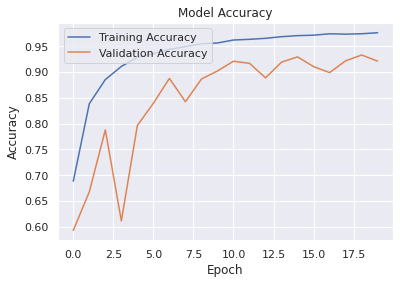

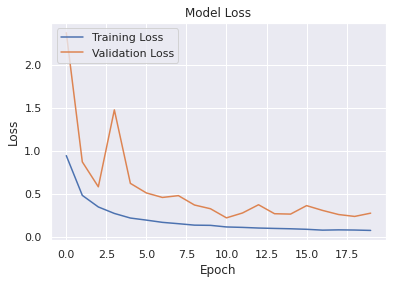


Accuracy score is : 0.9221975230231819
Precision score is : 0.9346215400280691
Recall score is : 0.9221975230231819
F1 Score is : 0.9262522956807402
Cohen Kappa Score : 0.8384423096315494
MCC : 0.840651085152709

Classification Report: 
                      precision    recall  f1-score   support

        Foreign body      0.811     0.916     0.861       155
             Erosion      0.479     0.911     0.628       101
    Lymphangiectasia      0.764     0.932     0.840       118
             Pylorus      0.696     0.859     0.769       306
               Polyp      0.900     0.818     0.857        11
     Blood - hematin      0.667     1.000     0.800         2
               Ulcer      0.963     0.924     0.943       171
     Ileocecal valve      0.873     0.897     0.885       838
       Blood - fresh      0.978     0.989     0.983        89
         Angiectasia      0.807     0.919     0.859       173
Reduced mucosal view      0.825     0.854     0.839       581
    Ampulla of va

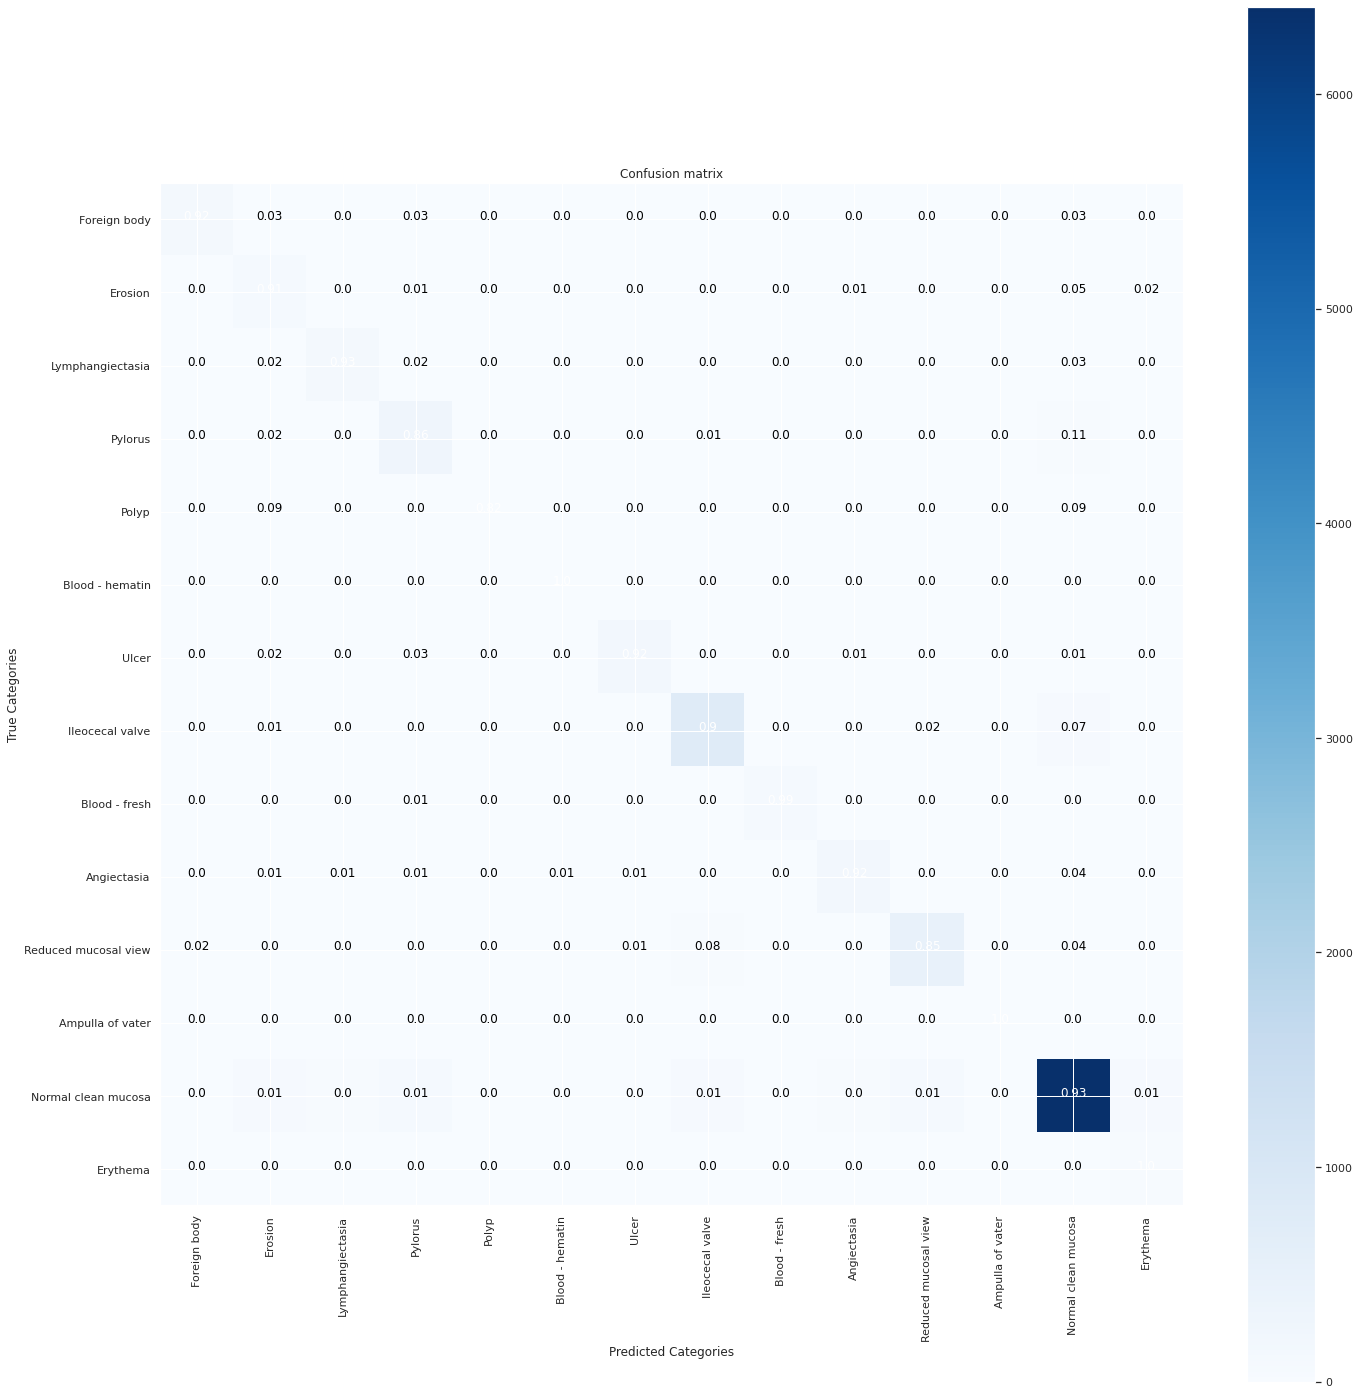

In [ ]:
true_categories, predicted_categories = calculate_true_and_predicted_cat(model, dataset)
print(true_categories)
print(predicted_categories)
using_evaluation_metrics(model_train, true_categories, predicted_categories)

# Plot the Confusion Matrix
cm = metrics.confusion_matrix(true_categories, predicted_categories)
plot_confusion_matrix(cm, CLASS_NAMES)

save_model()